In [2]:
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np
import os
from pathlib import Path
import json
import collections
from src.visualize import filter_path_1, filter_path_2, get_scores, get_scores_json, plot_scores, calculate_average_ranking, calculate_average_score

In [3]:
import os
import time

def get_last_modified_date(path, filename):
    files_dates = []
    for root_dir, dirs, files in os.walk(path):
        for file in files:
            if file == filename:
                file_path = os.path.join(root_dir, file)
                timestamp = os.path.getmtime(file_path)
                files_dates.append((file_path, timestamp))

    # Sort files by date
    files_dates.sort(key=lambda x: x[1])

    for file_path, timestamp in files_dates:
        last_modified_date = time.ctime(timestamp)
        print(f"File: {file_path} Last Modified: {last_modified_date}")



# Replace 'your_directory_path' and 'your_file_name' with your values
dir_path = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_1/huggingface/flan_v1"
filename = "results.json"
# get_last_modified_date(dir_path, filename)

In [4]:
eval_ds = 'NLI_2'
n_samples = 200
tasks = ['NLI', 
         'Coreference', 
         'Math', 
         'Paraphrase',
         'QA', 
         'Reading Comp.']
base_path = f'./models/pythia/experiment_1/huggingface/flan_v1/c4_mixed_NLI/EleutherAI/pythia-160M-deduped_ckpt_False/checkpoint-70000/inference/flan_v1_task_ds/'

folders = [os.path.join(base_path, f"ds_key:{task}/n_samples_{n_samples}") for task in tasks]
# assert that all folders/files exists
# Check if all folders exist
for folder in folders:
    if not os.path.exists(folder):
        print(f"Folder does not exist: {folder}")


fig_save_path = "./models/pythia/experiment_1"
if not os.path.exists(fig_save_path):
    os.makedirs(fig_save_path)
# keywords = ["sentiment", "dataset", "checkpoint", "promptsource", "decoding", "gpt2", "c4", 'P_1_PQA']

print("Number of folders: ", len(folders))
keywords = ["ds_key:", "160M"]

Number of folders:  6


In [5]:
# import os
# import shutil

# # Define the root directory where the models are located
# root_dir = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_1/huggingface/flan_v1"

# # Iterate over all subdirectories
# for dirpath, dirnames, filenames in os.walk(root_dir):
#     # Check if 'results1.json' exists in the directory
#     if 'results1.json' in filenames:
#         # Construct the full file paths
#         src = os.path.join(dirpath, 'results1.json')
#         dst = os.path.join(dirpath, 'results.json')
#         # Copy 'results1.json' to 'results.json'
#         shutil.copy(src, dst)
#         print(f"Moved {src} to {dst}")

In [6]:
model_paths = [
    "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_1/huggingface/flan_v1/c4_mixed_NLI/EleutherAI/pythia-1.4B-deduped_ckpt_False/checkpoint-70000",
    "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_1/huggingface/flan_v1/c4_mixed_NLI/EleutherAI/pythia-160M-deduped_ckpt_False/checkpoint-70000",    
    "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_1/huggingface/flan_v1/ds_c4_small/EleutherAI/pythia-1.4B-deduped_ckpt_False/checkpoint-70000",
    "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_1/huggingface/flan_v1/ds_c4_small/EleutherAI/pythia-160M-deduped_ckpt_False/checkpoint-70000",
    "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_1/huggingface/flan_v1/c4_mixed_Summarization/EleutherAI/pythia-160M-deduped_ckpt_False/checkpoint-70000",
    "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_1/huggingface/flan_v1/c4_mixed_QA/EleutherAI/pythia-160M-deduped_ckpt_False/checkpoint-70000",
    "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_1/huggingface/flan_v1/c4_mixed_Commonsense/EleutherAI/pythia-160M-deduped_ckpt_False/checkpoint-70000",
    "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_1/huggingface/flan_v1/c4_mixed_QA/EleutherAI/pythia-1.4B-deduped_ckpt_False/checkpoint-70000",
]



results_subdir = "inference/lm-harness"
TASKS = ["MATH_TASKS", "NLI_TASKS", "READING_COMP_TASKS", "COMMONSENSE_TASKS", "SENTIMENT_TASKS", "CLOSED_BOOK_QA", "OPEN_BOOK_QA"]
keywords_1 = ["c4", "1.4B", "160M"] # + TASKS
keywords_2 = ["c4", "1.4B", "160M", "QA", "Commonsense", "Summarization", "NLI"]
results_dict = collections.defaultdict(dict)
# for model_path in model_paths:
#     for task in TASKS:
#         result_file = os.path.join(model_path, results_subdir, task,  "results.json")
#         if not os.path.isfile(result_file):
#             print(f"File does not exist: {result_file}")
#             continue
#         else:
#             with open(result_file, "r") as f:
#                 results = json.load(f)
#                 filtered_path = filter_path(result_file, keywords)
#                 results_dict[task][filtered_path] = results
# print(f"Found {len(results_dict)} results.json files.")

results_dict = collections.defaultdict(dict)
for model_path in model_paths:
    for root, dirs, files in os.walk(model_path):
        if 'results.json' in files:
            result_file = os.path.join(root, 'results.json')
            with open(result_file, "r") as f:
                results = json.load(f)
                filtered_path = filter_path_2(filter_path_1(result_file, keywords_1), keywords_2)
                # Extract dataset name from the path
                relative_path = os.path.relpath(root, model_path)
                dataset = relative_path.split(os.sep)[0]
                # Merge the results under the model key
                if 'results' in results:
                    for dataset_name, dataset_results in results['results'].items():
                        results_dict[dataset_name][filtered_path] = dataset_results
print(f"Found results for {len(results_dict)} models.")


# additional ds record drop
task_to_dataset = {
    "MATH": ["math_algebra", "math_counting_and_prob", "mathqa", "math_precalc"],
    "NLI": ["mnli", "qnli", "anli_r1", "rte", "anli_r2", "anli_r3", "cb", "wnli"],
    "READING_COMP": ["multirc", "boolq", "squad2"],
    "COMMONSENSE": ["copa", "hellaswag"],
    "SENTIMENT": ["sst"],
    "CLOSED_BOOK_QA": ["arc_challenge", "arc_easy"],
    "OPEN_BOOK_QA": ["openbookqa"],
}

required_models = set([filter_path_2(filter_path_1(path, keywords_1), keywords_2) for path in model_paths])

def check_datasets(results_dict, task_to_dataset, required_models):
    missing_datasets = []
    for task, dataset_list in task_to_dataset.items():
        for dataset in dataset_list:
            if dataset not in results_dict:
                missing_datasets.append((task, dataset))
            else:
                for model in required_models:
                    if model not in results_dict[dataset]:
                        missing_datasets.append((task, dataset, model))
    return missing_datasets

missing_datasets = check_datasets(results_dict, task_to_dataset, required_models)

if missing_datasets:
    print("Missing datasets:")
    for missing in missing_datasets:
        if len(missing) == 3:
            task, dataset, model = missing
            print(f"Task: {task}, Dataset: {dataset}, Model: {model}")
        else:
            task, dataset = missing
            print(f"Task: {task}, Dataset: {dataset}")
else:
    print("All models have all the required datasets for all tasks.")

# Initialize the nested dictionary
results_dict_tasks = collections.defaultdict(lambda: collections.defaultdict(dict))

# Iterate over the results_dict
for dataset, models in results_dict.items():
    # Iterate over the models for each dataset
    for model, results in models.items():
        # Find the task corresponding to the dataset
        for task, dataset_list in task_to_dataset.items():
            if dataset in dataset_list:
                # Add the results to the nested dictionary under the dataset->model->task
                results_dict_tasks[task][model][dataset] = results

print(f"Found results for {len(results_dict_tasks)} datasets.")

Found results for 24 models.
All models have all the required datasets for all tasks.
Found results for 7 datasets.


In [7]:
required_models

required_models_1 = [filter_path_1(path, keywords_1) for path in model_paths]
required_models = [filter_path_2(filter_path_1(path, keywords_1), keywords_2) for path in model_paths]

print(required_models_1)
print(required_models)

print(len(required_models_1))
print(len(required_models))

print(len(set(required_models_1)))
print(len(set(required_models)))

['c4_mixed_NLI/pythia-1.4B-deduped_ckpt_False', 'c4_mixed_NLI/pythia-160M-deduped_ckpt_False', 'ds_c4_small/pythia-1.4B-deduped_ckpt_False', 'ds_c4_small/pythia-160M-deduped_ckpt_False', 'c4_mixed_Summarization/pythia-160M-deduped_ckpt_False', 'c4_mixed_QA/pythia-160M-deduped_ckpt_False', 'c4_mixed_Commonsense/pythia-160M-deduped_ckpt_False', 'c4_mixed_QA/pythia-1.4B-deduped_ckpt_False']
['c4 1.4B NLI', 'c4 160M NLI', 'c4 1.4B', 'c4 160M', 'c4 160M Summarization', 'c4 160M QA', 'c4 160M Commonsense', 'c4 1.4B QA']
8
8
8
8


In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

for dataset, models in results_dict.items():
    # Extract F1 scores for all models for the dataset
    f1_scores = [metrics.get('f1') for metrics in models.values() if 'f1' in metrics]
    
    # Remove None values if 'f1' key did not exist in any model
    f1_scores = [score for score in f1_scores if score is not None]
    
    if f1_scores:  # Check if f1_scores list is not empty
        # Reshape the scores to fit the scaler
        f1_scores = np.array(f1_scores).reshape(-1, 1)
        
        # Fit the scaler and transform the scores
        normalized_scores = scaler.fit_transform(f1_scores)
        
        # Scale the normalized scores to a range between 0 and 0.5
        scaled_scores = normalized_scores * 0.5
        
        # Update the F1 scores in the results_dict
        for model, scaled_score in zip(models.keys(), scaled_scores):
            if 'f1' in models[model]:
                models[model]['f1'] = scaled_score[0]

In [9]:
import json

metrics_dict = {
    'squad2': 'f1',
}

# Accessing the 'MATH_TASKS' results from the results dictionary
accuracy_results = collections.defaultdict(lambda: collections.defaultdict(dict))
required_metric = ('acc_norm', 'acc_norm_stderr')
alternate_metric = ('acc', 'acc_stderr')

for task in results_dict_tasks:
    task_results = results_dict_tasks[task]
    for model in task_results:
        model_results = task_results[model]
        datasets_metric = []
        for dataset in model_results:
            dataset_results = model_results[dataset]
            metric_used = None
            if required_metric[0] in dataset_results and required_metric[1] in dataset_results:
                metric_used = required_metric
            elif alternate_metric[0] in dataset_results and alternate_metric[1] in dataset_results:
                metric_used = alternate_metric
            elif dataset in metrics_dict:
                metric_used = metrics_dict[dataset]
            else:
                print(f"Neither required nor alternate metric found in task {task} dataset {dataset}")
                continue
            if isinstance(metric_used, tuple):
                datasets_metric.append(dataset_results[metric_used[0]])
            else:
                datasets_metric.append(dataset_results[metric_used])
            model_dict = accuracy_results[task].setdefault(model, {})
            model_dict['metric'] = np.mean(datasets_metric)

In [10]:
# Assuming the dictionaries are stored in 'accuracy_results'
closed_book_qa = accuracy_results['CLOSED_BOOK_QA']
open_book_qa = accuracy_results['OPEN_BOOK_QA']

# Initialize a new dictionary for the averaged results
averaged_results = {}

# Iterate over the keys and values of the first dictionary
for key, value_dict1 in closed_book_qa.items():
    # If the key also exists in the second dictionary, average the values
    if key in open_book_qa:
        value_dict2 = open_book_qa[key]
        averaged_value = (value_dict1['metric'] + value_dict2['metric']) / 2
        averaged_results[key] = {'metric': averaged_value}

accuracy_results['QA'] = averaged_results
del accuracy_results['CLOSED_BOOK_QA']
del accuracy_results['OPEN_BOOK_QA']

In [11]:
# filename_txt = 'rank.txt'
# scores_dict = get_scores(folders, filename_txt)
# title = 'Rank Classification (Lower is Better)'
# plot_scores(scores_dict, title)

In [12]:
# filename_logprob = 'log_probs.txt'
# scores_dict = get_scores(folders, filename_logprob)
# title = 'Log Probability (Less negative is Better)'
# plot_scores(scores_dict, title)

In [13]:
# file_paths = folders

# rank_dict = get_scores_json(file_paths, 'rank.json')
# logprob_dict = get_scores_json(file_paths, 'log_probs.json')


# print(len(rank_dict))

In [14]:
results_dict['sst']

{'c4 1.4B NLI': {'acc': 0.5424311926605505,
  'acc_stderr': 0.016880739025446814},
 'c4 160M NLI': {'acc': 0.5103211009174312,
  'acc_stderr': 0.016938243838576613},
 'c4 1.4B': {'acc': 0.5114678899082569, 'acc_stderr': 0.016937396972070192},
 'c4 160M': {'acc': 0.6307339449541285, 'acc_stderr': 0.016352483446031435},
 'c4 160M Summarization': {'acc': 0.5034403669724771,
  'acc_stderr': 0.016941452632752714},
 'c4 160M QA': {'acc': 0.5298165137614679, 'acc_stderr': 0.016911703415318845},
 'c4 160M Commonsense': {'acc': 0.5321100917431193,
  'acc_stderr': 0.016906881526426512},
 'c4 1.4B QA': {'acc': 0.5091743119266054, 'acc_stderr': 0.016939001525351542}}

/tmp/ipykernel_1376650/600684034.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_models))


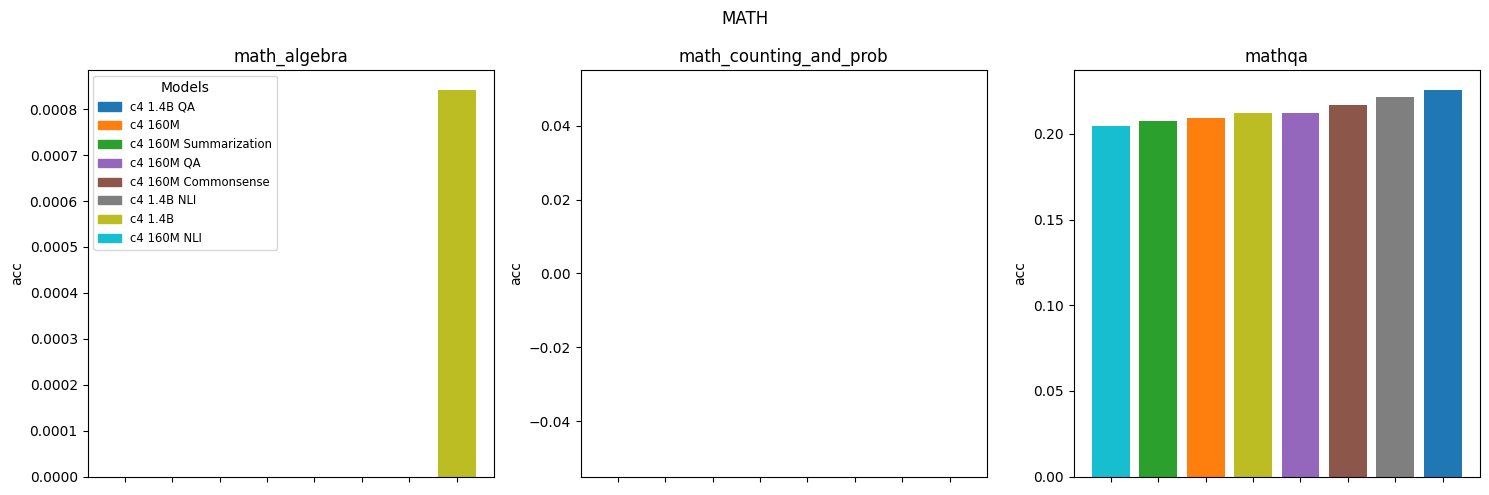

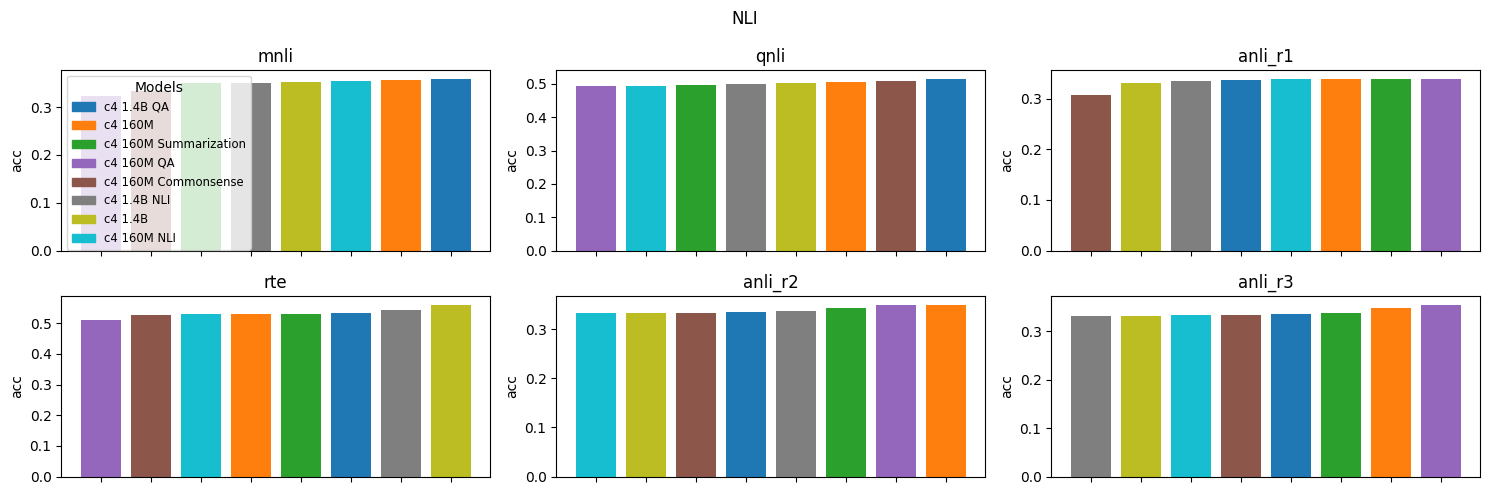

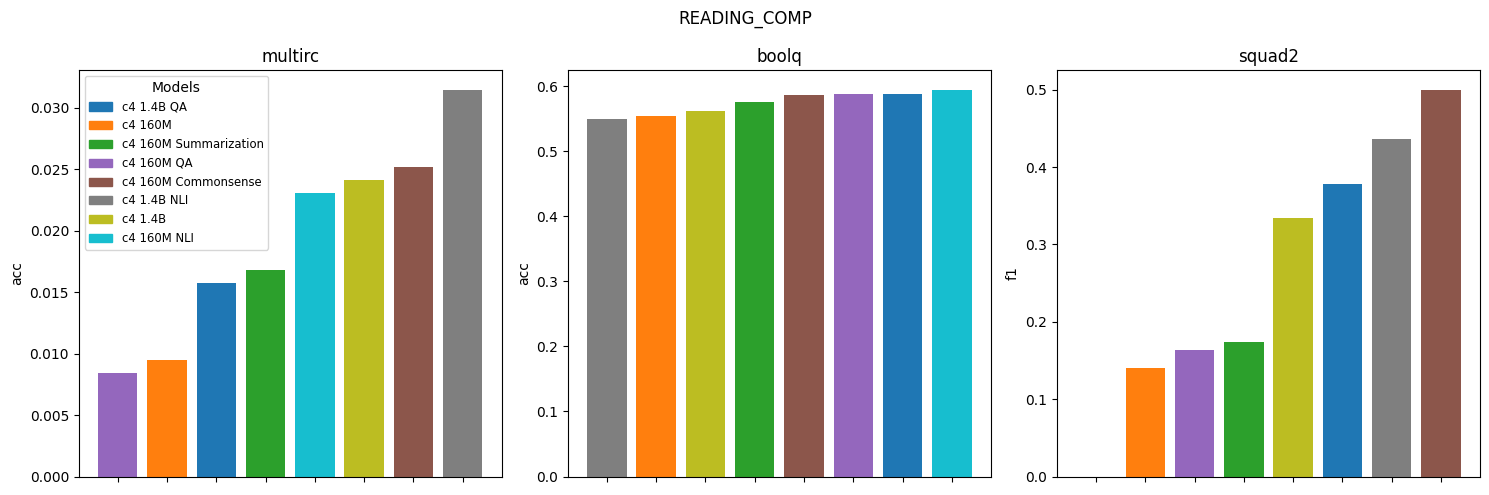

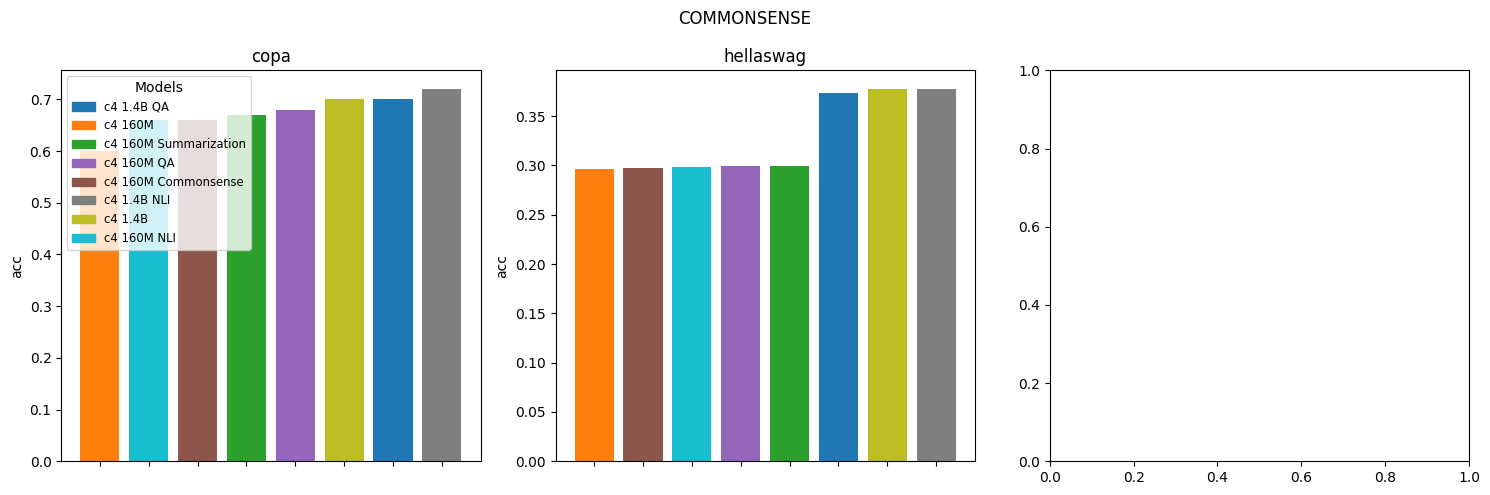

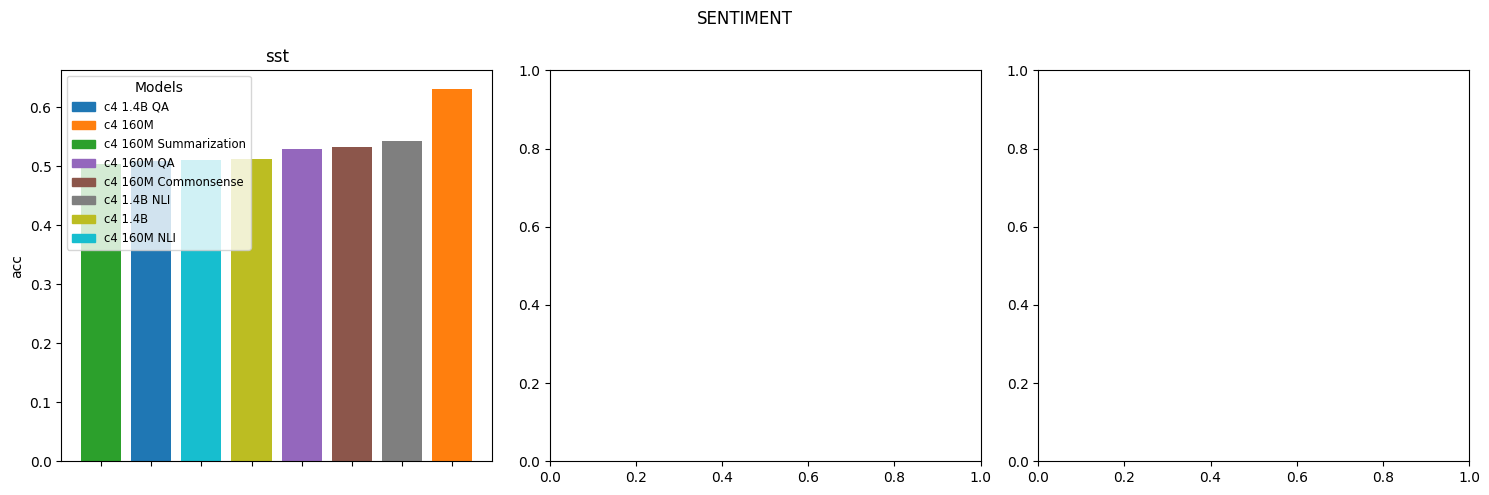

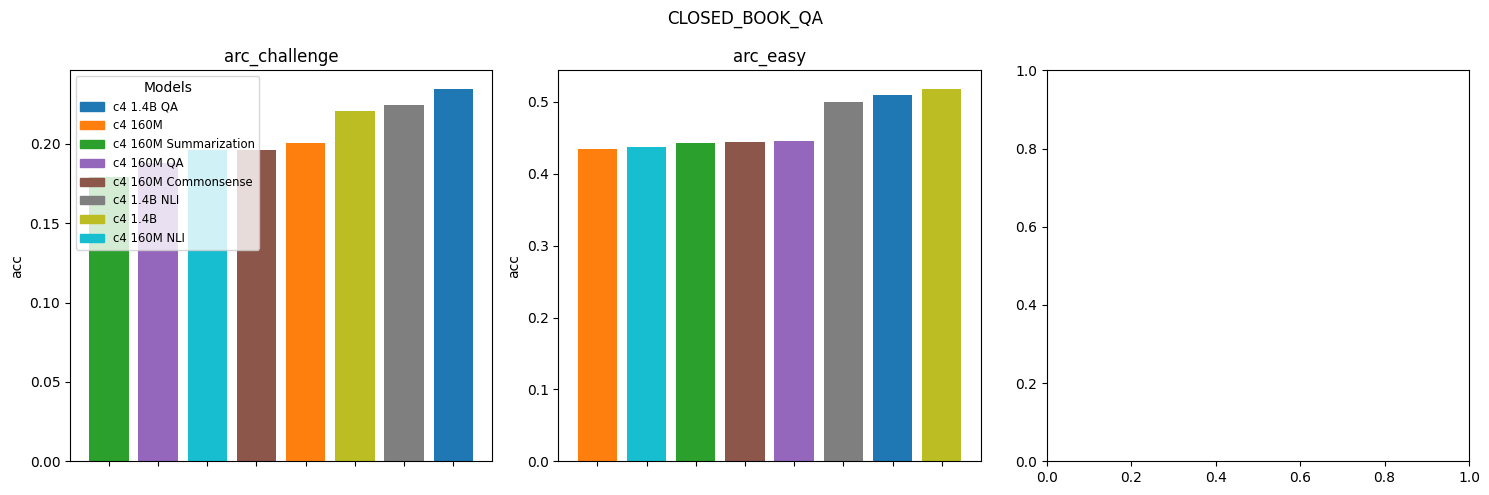

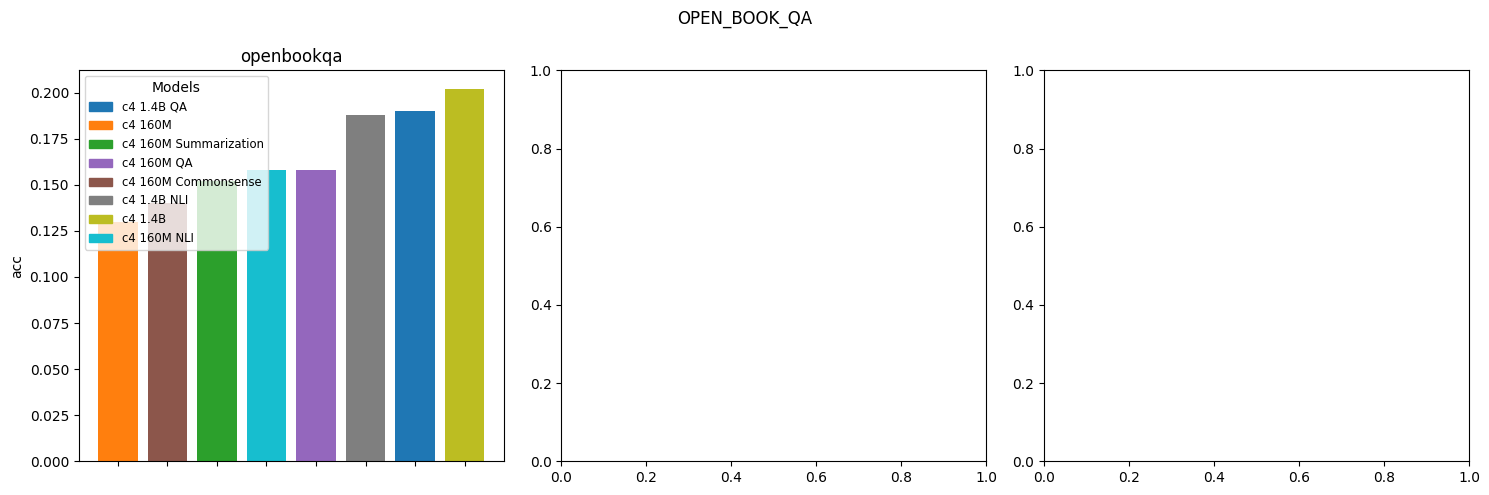

In [15]:
tasks = list(task_to_dataset.keys())
metric = ['acc', 'f1']
n_datasets = len(results_dict.keys())
TASK_PLOT_PATH = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/results/exp1/task_plots"

import matplotlib.colors as mcolors

# Get a list of unique model names
unique_models = list(set([model for _, models in results_dict.items() for model in models]))

# Create a color map
colors = plt.cm.get_cmap('tab10', len(unique_models))

# Create a dictionary mapping model names to colors
model_to_color = {model: colors(i) for i, model in enumerate(unique_models)}

for task in tasks:
    datasets = task_to_dataset[task]
    n_datasets = len(datasets)
    num_cols = 3
    num_rows = max(1, n_datasets // num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5))

    axs = axs.flatten()
    title = 'Accuracy'

    for ax, dataset in zip(axs, datasets):
        models = results_dict[dataset]
        model_names = []
        model_scores = []
        model_colors = []  # List to store colors for each model
        for model, results in models.items():
            sel_metric = metric[0] if metric[0] in results else metric[1]
            if sel_metric not in results:
                continue
            model_names.append(model)
            model_scores.append(results[sel_metric])
            model_colors.append(model_to_color[model])  # Get the color for the model

        # Sort the scores and their corresponding names and colors
        sorted_scores_indices = np.argsort(model_scores)
        model_scores = [model_scores[i] for i in sorted_scores_indices]
        model_names = [model_names[i] for i in sorted_scores_indices]
        model_colors = [model_colors[i] for i in sorted_scores_indices]

        bars = ax.bar(model_names, model_scores, color=model_colors)  # Add color parameter to bar plot
        ax.set_title(dataset)
        # if max(model_scores) < 1:
        #     ax.set_ylim([0, 1])
        # else:
        #     ax.set_ylim([0, max(model_scores)*1.2])
        ax.set_ylabel(sel_metric)
        ax.set_xticklabels([])  # Remove x-labels

        # Create a legend only for the first axis
        if ax is axs[0]:
            handles = [plt.Rectangle((0,0),1,1, color=model_to_color[model]) for model in unique_models]
            ax.legend(handles, unique_models, title="Models", loc='upper left', bbox_to_anchor=(0, 1), fontsize='small')

        # SAVE
        plt.savefig(f"{TASK_PLOT_PATH}/{task}.png", bbox_inches='tight')

    plt.suptitle(task)  # Set the figure title to the task name
    plt.tight_layout()
    plt.show()

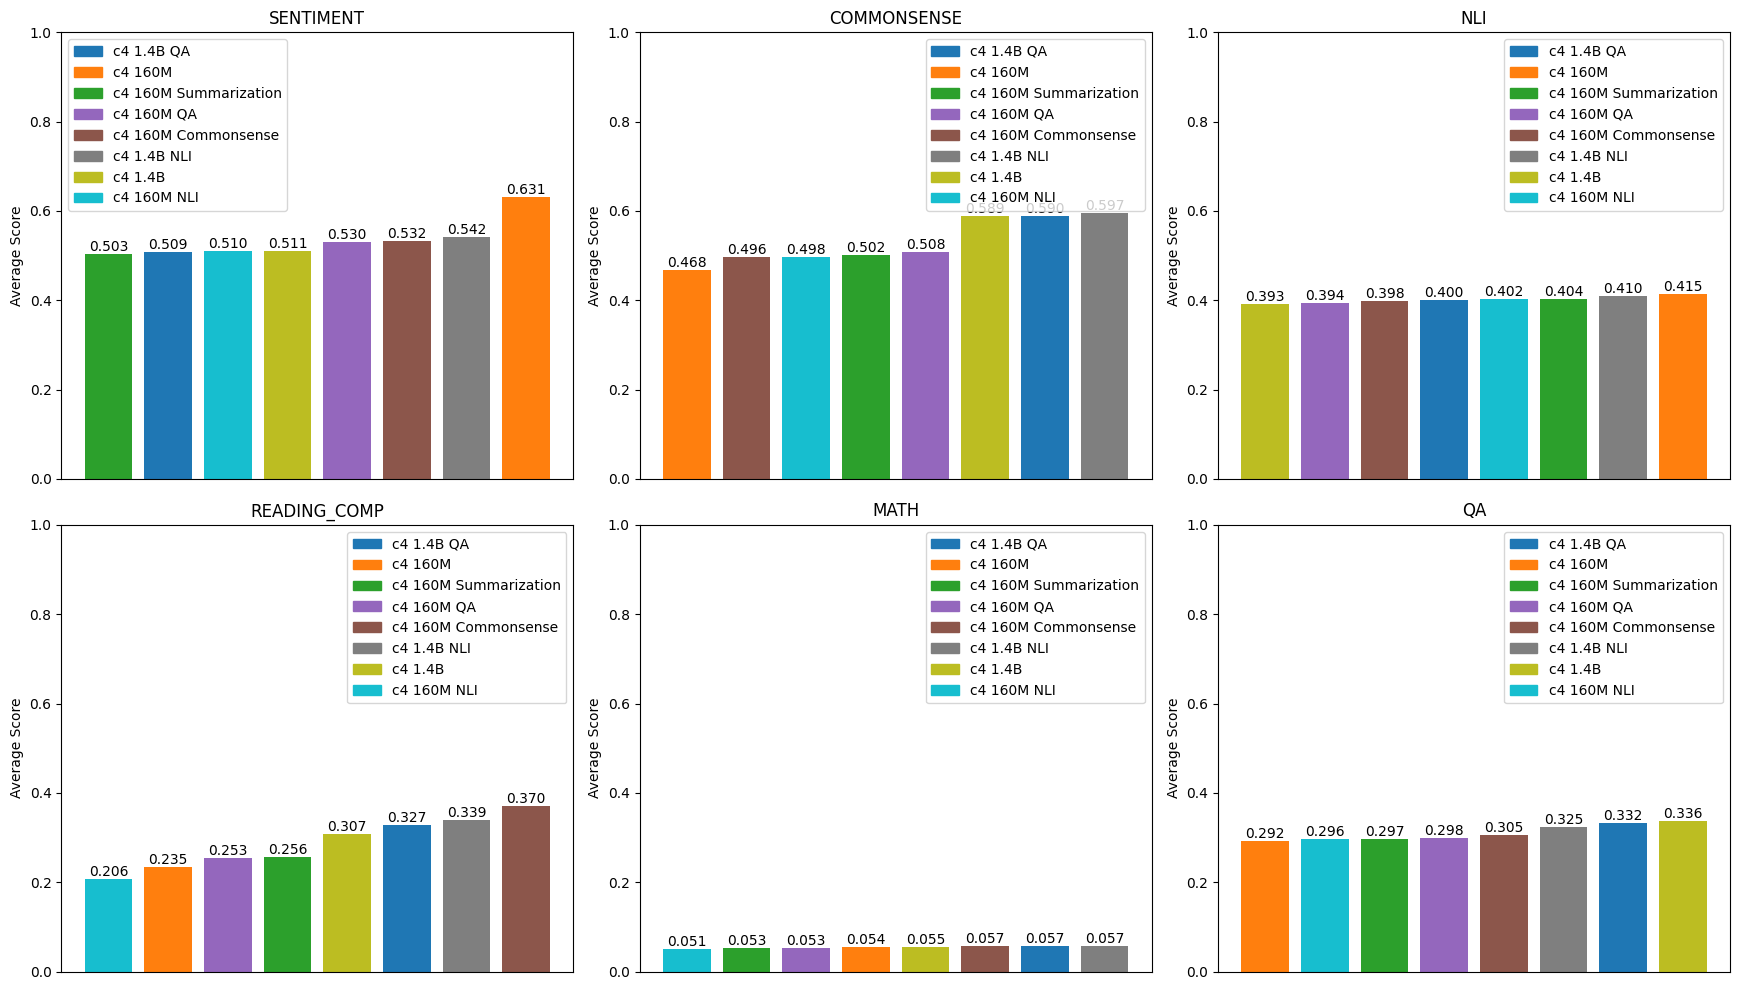

In [16]:
# Determine the number of rows needed for the subplots
num_tasks = len(accuracy_results)
num_cols = 3
num_rows = num_tasks // num_cols + (num_tasks % num_cols > 0)

# Create a figure with multiple subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(17.5, num_rows * 5))

# Flatten the axs array in case it's 2D
axs = axs.flatten()

# Iterate over the tasks and plot each on a different axis
title = 'Accuracy'
for ax, (task, accuracy_task) in zip(axs, accuracy_results.items()):
    plot_scores(accuracy_task, keywords=keywords, 
                title=task, metric='metric', std_metric=None, ax=ax)

# If there are more axes than tasks, remove the extra ones
for ax in axs[num_tasks:]:
    ax.remove()

plt.savefig(f"{TASK_PLOT_PATH}/all_tasks.png", bbox_inches='tight')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [19]:
average_rankings = calculate_average_ranking(accuracy_results)
average_score = calculate_average_score(accuracy_results)
print(average_rankings)
print(average_score)

{'c4 1.4B NLI': 1.8333333333333333, 'c4 1.4B QA': 3.5, 'c4 160M Commonsense': 4.0, 'c4 1.4B': 4.166666666666667, 'c4 160M': 5.0, 'c4 160M QA': 5.333333333333333, 'c4 160M Summarization': 5.666666666666667, 'c4 160M NLI': 6.5}
{'c4 1.4B NLI': 0.37829649931478354, 'c4 1.4B QA': 0.3692787163602229, 'c4 1.4B': 0.3651940834340195, 'c4 160M Commonsense': 0.3598381000572583, 'c4 160M': 0.34894209409875643, 'c4 160M QA': 0.33930118676864596, 'c4 160M Summarization': 0.3359793114703988, 'c4 160M NLI': 0.32723257623159974}


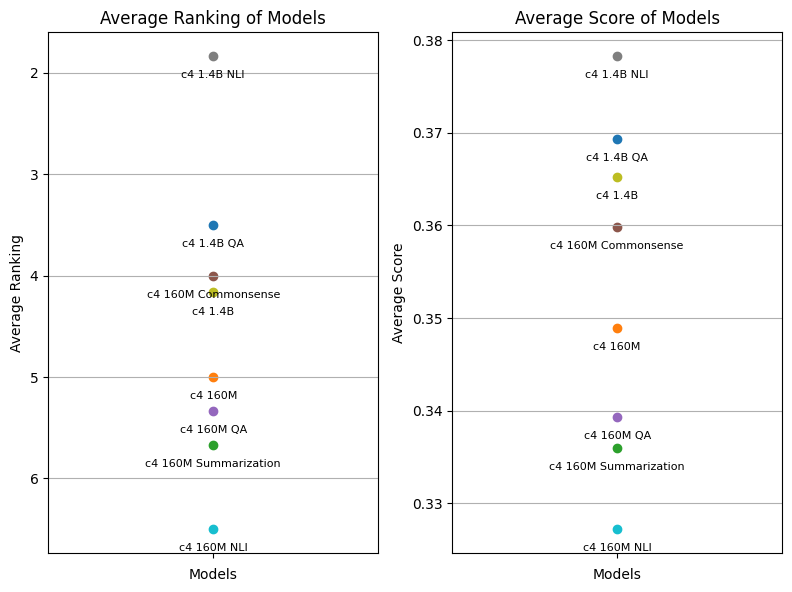

In [22]:
# Create lists for the plot
models_rankings = list(average_rankings.keys())
avg_rankings = list(average_rankings.values())

models_scores = list(average_score.keys())
avg_scores = list(average_score.values())

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Plot average rankings
for i, model in enumerate(models_rankings):
    axs[0].scatter('', avg_rankings[i], color=model_to_color[model])
axs[0].set_xlabel('Models')
axs[0].set_ylabel('Average Ranking')
axs[0].set_title('Average Ranking of Models')
for i, model in enumerate(models_rankings):
    axs[0].annotate(model, ('', avg_rankings[i]), xytext=(0, -10), textcoords='offset points', ha='center', va='top', fontsize=8)
axs[0].invert_yaxis()
axs[0].grid(axis='y')

# Plot average scores
for i, model in enumerate(models_scores):
    axs[1].scatter('', avg_scores[i], color=model_to_color[model])
axs[1].set_xlabel('Models')
axs[1].set_ylabel('Average Score')
axs[1].set_title('Average Score of Models')
for i, model in enumerate(models_scores):
    axs[1].annotate(model, ('', avg_scores[i]), xytext=(0, -10), textcoords='offset points', ha='center', va='top', fontsize=8)
axs[1].grid(axis='y')

plt.tight_layout(pad=1.0)  # Increase padding
plt.show()

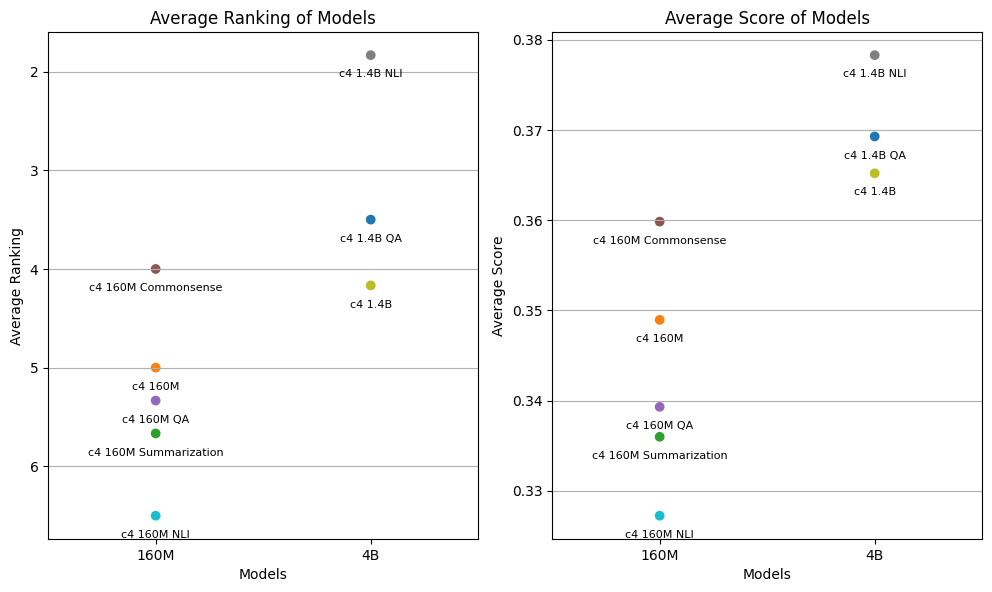

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Create lists for the plot
models_rankings = list(average_rankings.keys())
avg_rankings = list(average_rankings.values())

models_scores = list(average_score.keys())
avg_scores = list(average_score.values())

# Separate models based on parameter size
models_160M_rankings = [model for model in models_rankings if '160M' in model]
avg_rankings_160M = [avg_rankings[models_rankings.index(model)] for model in models_160M_rankings]

models_4B_rankings = [model for model in models_rankings if '4B' in model]
avg_rankings_4B = [avg_rankings[models_rankings.index(model)] for model in models_4B_rankings]

models_160M_scores = [model for model in models_scores if '160M' in model]
avg_scores_160M = [avg_scores[models_scores.index(model)] for model in models_160M_scores]

models_4B_scores = [model for model in models_scores if '4B' in model]
avg_scores_4B = [avg_scores[models_scores.index(model)] for model in models_4B_scores]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot average rankings
axs[0].scatter(['160M']*len(models_160M_rankings), avg_rankings_160M, color=[model_to_color[model] for model in models_160M_rankings])
axs[0].scatter(['4B']*len(models_4B_rankings), avg_rankings_4B, color=[model_to_color[model] for model in models_4B_rankings])

# Add model names as annotations
for i, model in enumerate(models_160M_rankings):
    axs[0].annotate(model, ('160M', avg_rankings_160M[i]), xytext=(0, -10), textcoords='offset points', ha='center', va='top', fontsize=8)
for i, model in enumerate(models_4B_rankings):
    axs[0].annotate(model, ('4B', avg_rankings_4B[i]), xytext=(0, -10), textcoords='offset points', ha='center', va='top', fontsize=8)

axs[0].set_xlabel('Models')
axs[0].set_ylabel('Average Ranking')
axs[0].set_title('Average Ranking of Models')
axs[0].invert_yaxis()
axs[0].grid(axis='y')
axs[0].set_xlim(-0.5, 1.5)  # Adjust x-axis limits

# Plot average scores
axs[1].scatter(['160M']*len(models_160M_scores), avg_scores_160M, color=[model_to_color[model] for model in models_160M_scores])
axs[1].scatter(['4B']*len(models_4B_scores), avg_scores_4B, color=[model_to_color[model] for model in models_4B_scores])

# Add model names as annotations
for i, model in enumerate(models_160M_scores):
    axs[1].annotate(model, ('160M', avg_scores_160M[i]), xytext=(0, -10), textcoords='offset points', ha='center', va='top', fontsize=8)
for i, model in enumerate(models_4B_scores):
    axs[1].annotate(model, ('4B', avg_scores_4B[i]), xytext=(0, -10), textcoords='offset points', ha='center', va='top', fontsize=8)

axs[1].set_xlabel('Models')
axs[1].set_ylabel('Average Score')
axs[1].set_title('Average Score of Models')
axs[1].grid(axis='y')
axs[1].set_xlim(-0.5, 1.5)  # Adjust x-axis limits

plt.tight_layout(pad=1.0)  # Increase padding
plt.show()

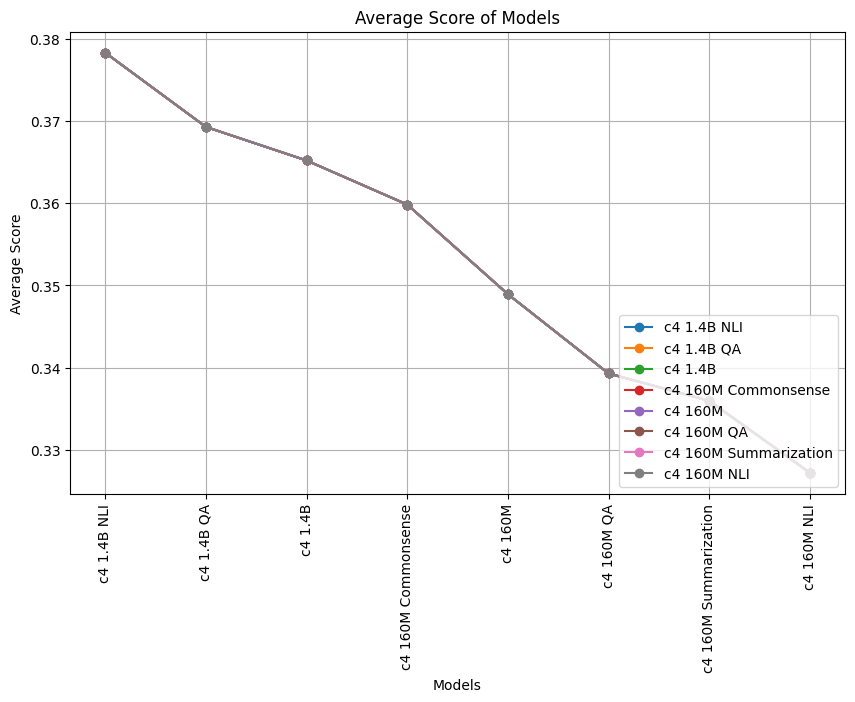

In [20]:
# Assuming 'average_score' is your dictionary of model scores
models = list(average_score.keys())
scores = list(average_score.values())

plt.figure(figsize=(10, 6))

# Plot each model's score as a line
for model, score in average_score.items():
    plt.plot(models, scores, marker='o')

plt.xticks(rotation=90)  # Rotate x-labels for readability
plt.xlabel('Models')
plt.ylabel('Average Score')
plt.title('Average Score of Models')
plt.legend(average_score.keys(), loc='lower right')  # Add a legend
plt.grid(True)  # Add a grid for better visibility of values
plt.show()

In [21]:
import pandas as pd

# Assuming the nested dictionary is stored in 'accuracy_results'
data = {}
for task, task_results in accuracy_results.items():
    for model, model_results in task_results.items():
        if model not in data:
            data[model] = {}
        data[model][task] = model_results['metric']

df = pd.DataFrame(data).T

In [22]:
df

,SENTIMENT,COMMONSENSE,NLI,READING_COMP,MATH,QA
c4 1.4B NLI,0.542431,0.596556,0.409994,0.339281,0.056951,0.324566
c4 160M NLI,0.510321,0.497795,0.402081,0.206064,0.050921,0.296213
c4 1.4B,0.511468,0.588996,0.392846,0.306904,0.055068,0.335882
c4 160M,0.630734,0.467696,0.414734,0.234605,0.053936,0.291947
c4 160M Summarization,0.503440,0.502497,0.404015,0.255836,0.052596,0.297492
c4 160M QA,0.529817,0.507895,0.393787,0.253226,0.052848,0.298235
c4 160M Commonsense,0.532110,0.496252,0.398488,0.370474,0.056784,0.304920
c4 1.4B QA,0.509174,0.589544,0.400479,0.327218,0.056868,0.332389


In [ ]:
keywords = ['QA', 'NLI', 'Summarization', 'Commonsense', '1.4B', '160M', 'ds']  # replace with your keywords

# Define a function to keep all the keywords in the string
def keep_keywords(s):
    found_keywords = [keyword for keyword in keywords if keyword in s]
    return '_'.join(found_keywords) if found_keywords else s

# Apply the function to the DataFrame index
df.index = df.index.map(keep_keywords)

df.to_csv(os.path.join('/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/results/exp1', 'exp1_results1.csv'))

In [ ]:
df